# 一、导包

In [3]:
# 安装 ultralytics（YOLOv8）
#%pip install -U ultralytics

# 可选：查看 TF/PyTorch/GPU 情况（YOLO使用PyTorch）
import torch, platform
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count(), "| Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("Python:", platform.python_version())
print("Platform:", platform.platform())

from pathlib import Path
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt

import shutil, torch


PyTorch: 2.7.0+cu126 | CUDA available: True
Device count: 1 | Device name: NVIDIA GeForce RTX 4060 Ti
Python: 3.11.11
Platform: Windows-10-10.0.22631-SP0


In [2]:
# 数据集划分脚本
import os
import random
import shutil
from pathlib import Path

# ========= 配置区域 =========
IMG_DIR = Path("dataset/images/train")    # 原训练集图像目录
LBL_DIR = Path("dataset/labels/train")    # 原训练集标签目录
VAL_RATIO = 0.2                             # 验证集比例：20%
OUT_DIR = Path("dataset/split")           # 输出根目录
# ==========================

OUT_IMG_TRAIN = OUT_DIR / "images/train"
OUT_IMG_VAL   = OUT_DIR / "images/val"
OUT_LBL_TRAIN = OUT_DIR / "labels/train"
OUT_LBL_VAL   = OUT_DIR / "labels/val"

for p in [OUT_IMG_TRAIN, OUT_IMG_VAL, OUT_LBL_TRAIN, OUT_LBL_VAL]:
    p.mkdir(parents=True, exist_ok=True)

# 支持的图片后缀
valid_exts = {".jpg", ".jpeg", ".png", ".bmp"}

images = [f for f in IMG_DIR.iterdir() if f.suffix.lower() in valid_exts]
random.shuffle(images)

val_count = int(len(images) * VAL_RATIO)

train_imgs = images[val_count:]
val_imgs = images[:val_count]

def copy_pair(img_path, img_dst_dir, lbl_dst_dir):
    # 匹配标签文件
    lbl_path = LBL_DIR / (img_path.stem + ".txt")
    # 复制图像
    shutil.copy2(img_path, img_dst_dir / img_path.name)
    # 若存在标签则复制
    if lbl_path.exists():
        shutil.copy2(lbl_path, lbl_dst_dir / lbl_path.name)

for img in train_imgs:
    copy_pair(img, OUT_IMG_TRAIN, OUT_LBL_TRAIN)

for img in val_imgs:
    copy_pair(img, OUT_IMG_VAL, OUT_LBL_VAL)

print(f"总图像数: {len(images)}")
print(f"训练集: {len(train_imgs)}")
print(f"验证集: {len(val_imgs)}")
print(f"输出路径: {OUT_DIR.resolve()}")

总图像数: 3300
训练集: 2640
验证集: 660
输出路径: D:\Homework\MathorCup\work\dataset\split


# 二、创建dataset.yaml

In [5]:
# ====== 按需修改你的数据根路径 ======
DATASET_ROOT = r"D:/Homework/MathorCup/work/dataset/split"  # 你的数据根目录
IMAGES_DIR   = Path(DATASET_ROOT)/"images"  # 约定 images/{train,val,test}
LABELS_DIR   = Path(DATASET_ROOT)/"labels"  # 约定 labels/{train,val,test}

# 类别名称（顺序要与你的 class id 对应）
CLASSES = ["dent", "hole", "rusty"]  # 示例，按需修改

# 生成 dataset.yaml（写到当前目录）
ds = {
    "path": str(Path(DATASET_ROOT).as_posix()),  # 可选，不一定必须
    "train": str((IMAGES_DIR/"train").as_posix()),
    "val":   str((IMAGES_DIR/"val").as_posix()),
    "test":  str((IMAGES_DIR/"test").as_posix()),
    "names": {i: name for i, name in enumerate(CLASSES)}  # YOLO11 接受 dict 索引:名称
}

yaml_path = Path("./dataset.yaml")
balanced_yaml_path = Path("./dataset_balanced.yaml")
with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(ds, f, sort_keys=False, allow_unicode=True)
print("已写入:", yaml_path.resolve())
print(ds)


已写入: D:\Homework\MathorCup\work\dataset.yaml
{'path': 'D:/Homework/MathorCup/work/dataset/split', 'train': 'D:/Homework/MathorCup/work/dataset/split/images/train', 'val': 'D:/Homework/MathorCup/work/dataset/split/images/val', 'test': 'D:/Homework/MathorCup/work/dataset/split/images/test', 'names': {0: 'dent', 1: 'hole', 2: 'rusty'}}


In [6]:
EPOCHS     = 400
IMGSZ      = 640
BATCH      = 16 
WORKERS    = 4   

# 三、开始训练

## yolo11增强

In [1]:
import os
from pathlib import Path

# 1) 路径根据你的数据组织修改
IMAGES_DIR = Path(r"D:\Homework\MathorCup\work\dataset\split\images\train")
LABELS_DIR = Path(r"D:\Homework\MathorCup\work\dataset\split\labels\train")

# 2) 类别 id 与重复因子
REPEAT = {
    0: 1,  # dent
    1: 2,  # hole  少数类→加大
    2: 3,  # rusty 难样本→加大
}

# 3) 生成过采样的图片路径列表（按包含的“最高重复因子”的类来决定该图重复几次）
def max_repeat_for_label(label_path: Path) -> int:
    if not label_path.exists():
        return 1
    reps = [1]
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            cid = int(parts[0])
            reps.append(REPEAT.get(cid, 1))
    return max(reps)

def image_to_label(img_path: Path) -> Path:
    return LABELS_DIR / (img_path.stem + ".txt")

all_imgs = []
for p in sorted(IMAGES_DIR.rglob("*.*")):
    if p.suffix.lower() not in {".jpg", ".jpeg", ".png", ".bmp"}:
        continue
    rep = max_repeat_for_label(image_to_label(p))
    all_imgs.extend([str(p.resolve())] * rep)

out_txt = Path(r"D:\Homework\MathorCup\work\dataset\train_oversample.txt")
out_txt.write_text("\n".join(all_imgs), encoding="utf-8")
print(f"写入完成：{out_txt}  共 {len(all_imgs)} 行")


写入完成：D:\Homework\MathorCup\work\dataset\train_oversample.txt  共 4371 行


In [10]:
# 选择模型：yolo11n.pt（小/快） | yolo11s.pt | yolo11m.pt | yolo11l.pt | yolo11x.pt
MODEL_NAME = "yolo11n.pt"  # 显存小先用n或s
EPOCHS     = 300
IMGSZ      = 640
BATCH      = 16  # 显存不够就改小，如 8 或 4
WORKERS    = 4   # Windows上可设为 0~4


model = YOLO(MODEL_NAME)  # 会自动下载预训练权重
res = model.train(
    data=str("dataset.yaml"),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    workers=WORKERS,
    seed=42,
    device=0 if torch.cuda.is_available() else "cpu",  # 指定GPU 0；无GPU则CPU
    project="runs/detect",
    name="train11t",
    exist_ok=True
)
print("训练完成，权重目录：", res.save_dir)

Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train11t, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

In [2]:
# 选择模型：yolo11n.pt（小/快） | yolo11s.pt | yolo11m.pt | yolo11l.pt | yolo11x.pt
MODEL_NAME = "yolo11n.pt"  # 显存小先用n或s
EPOCHS     = 300
IMGSZ      = 640
BATCH      = 16  # 显存不够就改小，如 8 或 4
WORKERS    = 4   # Windows上可设为 0~4


model = YOLO(MODEL_NAME)  # 会自动下载预训练权重
res = model.train(
    data=str("dataset_os.yaml"),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    workers=WORKERS,
    seed=42,
    device=0 if torch.cuda.is_available() else "cpu",  # 指定GPU 0；无GPU则CPU
    project="runs/detect",
    name="train11t",
    exist_ok=True
)
print("训练完成，权重目录：", res.save_dir)

Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_os.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train11t, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

KeyboardInterrupt: 

## yolo11

In [ ]:
# 选择模型：yolo11n.pt（小/快） | yolo11s.pt | yolo11m.pt | yolo11l.pt | yolo11x.pt
MODEL_NAME = "yolo11n.pt"  # 显存小先用n或s
EPOCHS     = 300
IMGSZ      = 640
BATCH      = 16  # 显存不够就改小，如 8 或 4
WORKERS    = 4   # Windows上可设为 0~4

model = YOLO(MODEL_NAME)  # 会自动下载预训练权重
res = model.train(
    data=str('dataset.yaml'),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    workers=WORKERS,
    seed=42,
    device=0 if torch.cuda.is_available() else "cpu",  # 指定GPU 0；无GPU则CPU
    project="runs/detect",
    name="train11",
    exist_ok=True
)
print("训练完成，权重目录：", res.save_dir)


Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train11, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

KeyboardInterrupt: 

In [ ]:
# 选择模型：yolov8n.pt（小/快） | yolov8s.pt | yolov8m.pt | yolov8l.pt | yolov8x.pt
MODEL_NAME = "yolov8n.pt"  # 显存小先用n或s
EPOCHS     = 300
IMGSZ      = 640
BATCH      = 16 
WORKERS    = 4   

model = YOLO(MODEL_NAME)  # 会自动下载预训练权重
res = model.train(
    data=str("dataset.yaml"),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    workers=WORKERS,
    seed=42,
    device=0 if torch.cuda.is_available() else "cpu",  # 指定GPU 0；无GPU则CPU
    project="runs/detect",
    name="trainv8",
    exist_ok=True
)
print("训练完成，权重目录：", res.save_dir)

Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=400, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=trainv8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

In [ ]:
# 选择模型：yolovnas.pt（小/快） | yolov8s.pt | yolov8m.pt | yolov8l.pt | yolov8x.pt
MODEL_NAME = "yolo_nas_n.pt"  # 显存小先用n或s
EPOCHS     = 400
IMGSZ      = 640
BATCH      = 16 
WORKERS    = 4   

model = YOLO(MODEL_NAME)  # 会自动下载预训练权重
res = model.train(
    data=str(yaml_path),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    workers=WORKERS,
    seed=42,
    device=0 if torch.cuda.is_available() else "cpu",  # 指定GPU 0；无GPU则CPU
    project="runs/detect",
    name="trainv8",
    exist_ok=True
)
print("训练完成，权重目录：", res.save_dir)

# 伪标签和学生模型


In [13]:
#1  配置参数
# 你的数据根
ROOT = Path(r"D:\Homework\MathorCup\work\dataset\split")

# 真标注训练/验证
IMG_TRAIN = ROOT / r"images\train"
LAB_TRAIN = ROOT / r"labels\train"
IMG_VAL   = ROOT / r"images\val"
LAB_VAL   = ROOT / r"labels\val"

# 未标注或“疑似漏标”的图片目录（没有就用验证集充当）
IMG_UNLAB = ROOT / r"images\train"  # 若不存在，改为：ROOT / r"images\val"

# 你的最佳权重（按训练输出实际路径修改）
WEIGHTS = Path(r"runs\detect\train11t\weights\best.pt")

# 伪标签输出目录（图片与txt会复制到此）
PSEUDO = ROOT.parent / "data_pseudo"
(PSEUDO / "images").mkdir(parents=True, exist_ok=True)
(PSEUDO / "labels").mkdir(parents=True, exist_ok=True)

# 预测文本临时输出目录
PRED_DIR = ROOT.parent / r"runs\pseudo\unlab_pred"

# 训练参数
IMGSZ = 640
BATCH = 16
DEVICE = 0 if torch.cuda.is_available() else "cpu"

# 类别名（仅用于可视化与日志）
NAMES = {0: "dent", 1: "hole", 2: "rust"}
print("设备:", DEVICE)


设备: 0


In [ ]:
#2 预测未标注图片

model = YOLO(str(WEIGHTS))
res = model.predict(
    source=str(IMG_UNLAB),
    imgsz=IMGSZ,
    conf=0.65,    # 第一层阈值（高置信）
    iou=0.60,
    save=False,
    save_txt=True,
    save_conf=True,
    project=str(PRED_DIR.parent),
    name=PRED_DIR.name,
    verbose=False,
    device=DEVICE
)
print("预测完成；预测txt位于：", PRED_DIR / "labels")


WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to D:\Homework\MathorCup\work\dataset\runs\pseudo\unlab_pred
2275 labels saved to D:\Homework\MathorCup\work\dataset\runs\pseudo\unlab_pred\labels
预测完成；预测txt位于： D:\Homework\MathorCup\work\dataset\runs\pseudo\unlab_pred\labels


In [14]:
#3 过滤与写入伪标签
from pathlib import Path

PRED_TXT = PRED_DIR / "labels"

# 过滤阈值
CONF_THRES = 0.75           # 第二层阈值
MIN_SIDE_PX = 10            # 最短边像素阈值（按推理分辨率计）
MIN_AREA_REL = (MIN_SIDE_PX/IMGSZ)**2
IOU_SUPPRESS_GT = 0.30      # 与已有GT同类且IoU>=此值则丢弃，避免重复
CLASS_WHITELIST = None      # 只补某类时设置，如只补rust：{2}；全部类别：None

def read_yolo_pred(p: Path):
    if not p.exists(): return []
    out=[]
    for line in p.read_text().strip().splitlines():
        s=line.split()
        if len(s)>=6:
            c,x,y,w,h,conf = int(float(s[0])), *map(float, s[1:5]), float(s[5])
        elif len(s)>=5:
            c,x,y,w,h,conf = int(float(s[0])), *map(float, s[1:5]), 1.0
        else:
            continue
        out.append((c,x,y,w,h,conf))
    return out

def read_gt(p: Path):
    if not p.exists(): return []
    out=[]
    for line in p.read_text().strip().splitlines():
        s=line.split()
        if len(s)>=5:
            c,x,y,w,h = int(float(s[0])), *map(float, s[1:5])
            out.append((c,x,y,w,h))
    return out

def iou_xywh(a, b):
    ax1, ay1 = a[0]-a[2]/2, a[1]-a[3]/2
    ax2, ay2 = a[0]+a[2]/2, a[1]+a[3]/2
    bx1, by1 = b[0]-b[2]/2, b[1]-b[3]/2
    bx2, by2 = b[0]+b[2]/2, b[1]+b[3]/2
    ix1, iy1 = max(ax1,bx1), max(ay1,by1)
    ix2, iy2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0.0, ix2-ix1), max(0.0, iy2-iy1)
    inter = iw*ih
    ua = (ax2-ax1)*(ay2-ay1) + (bx2-bx1)*(by2-by1) - inter
    return inter/ua if ua>0 else 0.0

# 开始过滤与写入
kept_files, kept_boxes = 0, 0
for pred_txt in sorted(PRED_TXT.glob("*.txt")):
    stem = pred_txt.stem

    # 找图像（同名不同后缀时取第一个）
    img_candidates = []
    for ext in [".jpg",".jpeg",".png",".bmp"]:
        p = (IMG_UNLAB / f"{stem}{ext}")
        if p.exists():
            img_candidates.append(p)
    if not img_candidates:
        continue
    img_path = img_candidates[0]

    preds = read_yolo_pred(pred_txt)
    # 如果这张图原训练集中已有GT，则用于抑制重复
    gts = read_gt(LAB_TRAIN / f"{stem}.txt")

    keep=[]
    for c,x,y,w,h,conf in preds:
        if conf < CONF_THRES:
            continue
        if CLASS_WHITELIST and c not in CLASS_WHITELIST:
            continue
        if w*h < MIN_AREA_REL:
            continue
        ok = True
        for gc,gx,gy,gw,gh in gts:
            if gc == c and iou_xywh((x,y,w,h),(gx,gy,gw,gh)) >= IOU_SUPPRESS_GT:
                ok = False; break
        if ok:
            keep.append((c,x,y,w,h))

    if not keep:
        continue

    # 复制图像到伪数据集
    dst_img = PSEUDO / "images" / img_path.name
    if not dst_img.exists():
        shutil.copy2(img_path, dst_img)

    # 写伪标签
    (PSEUDO / "labels").mkdir(exist_ok=True, parents=True)
    with open(PSEUDO / "labels" / f"{stem}.txt","w",encoding="utf-8") as f:
        for c,x,y,w,h in keep:
            f.write(f"{c} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
            kept_boxes += 1
    kept_files += 1

print(f"伪标签生成完成：{kept_files} 张图，{kept_boxes} 个框")
print("伪标签目录：", PSEUDO)


伪标签生成完成：76 张图，91 个框
伪标签目录： D:\Homework\MathorCup\work\dataset\data_pseudo


In [15]:
#4 生成伪样本清单文件
OUT_LIST = ROOT / "train_pseudo.txt"

def list_images(d: Path):
    return [p.resolve() for p in d.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}]

real_imgs = list_images(IMG_TRAIN)
pseudo_imgs = list_images(PSEUDO / "images")

# 真样本重复一次，等价于更高采样权重；可按需要调整比例
lines = [str(p) for p in pseudo_imgs]
OUT_LIST.write_text("\n".join(lines), encoding="utf-8")
print(f"写入伪样本清单：{OUT_LIST}  总行数={len(lines)}")


写入伪样本清单：D:\Homework\MathorCup\work\dataset\split\train_pseudo.txt  总行数=76


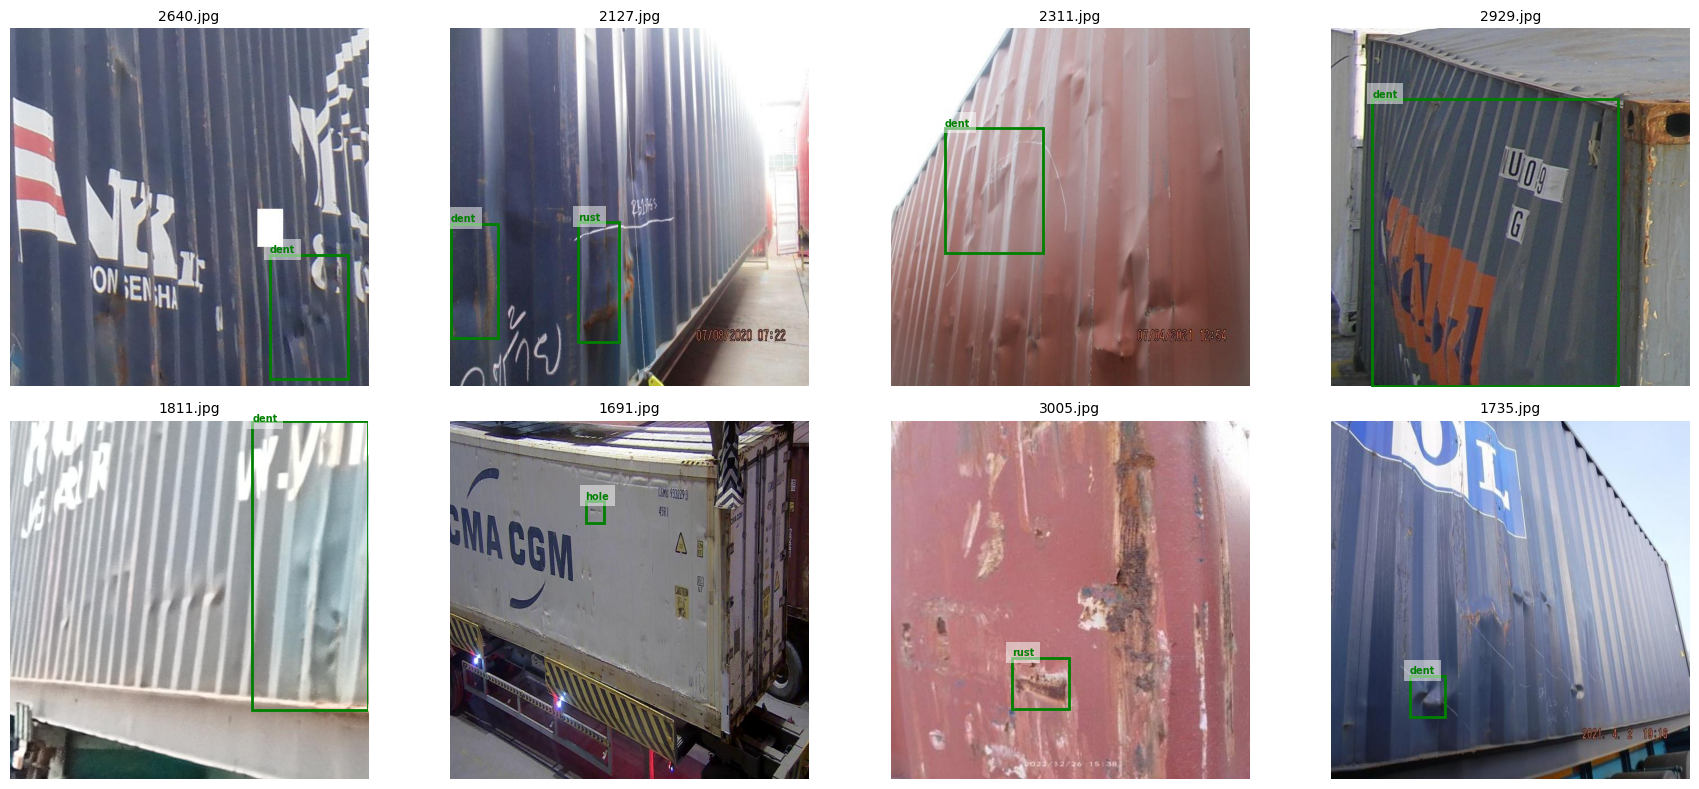

In [19]:
#5 可视化随机伪标签图像
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
%matplotlib inline


# ===== 配置你的伪样本路径 =====
ROOT = Path(r"D:\Homework\MathorCup\work\dataset\data_pseudo")  # 你的伪样本数据集
IMG_DIR = ROOT / "images"
LAB_DIR = ROOT / "labels"

# 类别名映射（按你实际类别）
NAMES = {0:"dent", 1:"hole", 2:"rust"}

SHOW_CONF = True  # 若伪标签中包含 conf 则设 True 显示置信度

def read_label(p):
    """读取 YOLO txt，兼容 conf 有无"""
    out=[]
    if not p.exists(): return out
    for line in p.read_text().strip().splitlines():
        s=line.split()
        if len(s)>=6:
            c,x,y,w,h,conf = int(float(s[0])), *map(float, s[1:5]), float(s[5])
        elif len(s)>=5:
            c,x,y,w,h,conf = int(float(s[0])), *map(float, s[1:5]), None
        else:
            continue
        out.append((c,x,y,w,h,conf))
    return out

def xywh2xyxy(x,y,w,h,W,H):
    return (x-w/2)*W, (y-h/2)*H, (x+w/2)*W, (y+h/2)*H

def show_random(k=12):
    imgs = [p for p in IMG_DIR.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}]
    if not imgs:
        print("伪样本图像不存在！检查目录:", IMG_DIR)
        return

    chosen = random.sample(imgs, min(k, len(imgs)))

    cols = 4
    rows = (len(chosen) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, rows*4))
    axes = axes.flatten()

    for ax, img_path in zip(axes, chosen):
        img = Image.open(img_path).convert("RGB")
        W,H = img.size
        ax.imshow(img)
        ax.set_title(img_path.name, fontsize=10)
        ax.axis("off")

        lab_path = LAB_DIR / (img_path.stem + ".txt")
        boxes = read_label(lab_path)

        # 绘制框
        for c,x,y,w,h,conf in boxes:
            x1,y1,x2,y2 = xywh2xyxy(x,y,w,h,W,H)
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                     fill=False, edgecolor="green", linewidth=2)
            ax.add_patch(rect)
            text = f"{NAMES.get(c,c)}"
            if SHOW_CONF and conf is not None:
                text += f" {conf:.2f}"
            ax.text(x1, max(0,y1-5), text,
                    color="green", fontsize=7, weight="bold",
                    bbox=dict(fc='white', alpha=0.5, edgecolor='none'))

    # 隐藏多余子图
    for ax in axes[len(chosen):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# 🔍随机展示 8 张伪标签图像
show_random(8)


In [20]:
#6 合并伪标签到训练集标签目录
from pathlib import Path

B = Path(r"D:\Homework\MathorCup\work\dataset\data_pseudo\labels")   # Windows 可写为 r"C:\path\to\A"
A = Path(r"D:\Homework\MathorCup\work\dataset\split\labels\mixtrain")

for f in B.glob("*.txt"):
    dst = A / f.name
    if dst.exists():  # 只在同名存在时追加
        with open(dst, "a", encoding="utf-8", newline="") as out, \
             open(f, "r", encoding="utf-8", newline="") as inp:
            out.write(inp.read())


In [22]:
#7 训练学生模型
from pathlib import Path
WEIGHTS = Path(r"runs\detect\train11t\weights\best.pt")

student = YOLO(str(WEIGHTS))
metrics = student.train(
    data=str("dataset_student.yaml"),
    imgsz=640,
    epochs=200,
    batch=16,
    device=0,
    seed=42,
    project="runs/detect",
    name="train11student2",
    exist_ok=True,
    close_mosaic = 30,
    patience = 200
)
print(metrics)


Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=30, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_student.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\train11t\weights\best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train11student2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

KeyboardInterrupt: 

In [2]:
#7 训练学生模型
from pathlib import Path
WEIGHTS = Path(r"runs\detect\train11t\weights\best.pt")

student = YOLO("yolo11n.pt")
metrics = student.train(
    data=str("dataset_student.yaml"),
    imgsz=640,
    epochs=300,
    batch=16,
    device=0,
    seed=42,
    project="runs/detect",
    name="train11student1",
    exist_ok=True,
)
print(metrics)

Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_student.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train11student1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

In [ ]:
#7 训练学生模型
from pathlib import Path
WEIGHTS = Path(r"runs\detect\train11t\weights\best.pt")

student = YOLO("yolo11n.pt")
metrics = student.train(
    data=str("dataset_student.yaml"),
    imgsz=640,
    epochs=300,
    batch=16,
    device=0,
    seed=42,
    project="runs/detect",
    name="train11student3",
    exist_ok=True,
)
print(metrics)

Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_student.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train11student3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

# 一堆评估模型

In [6]:
from pathlib import Path
# 评估模型（在训练模型中已经自动生成）
best_ckpt = Path("runs/detect/train11t/weights/best.pt")
assert best_ckpt.exists(), "未找到 best.pt，请检查训练输出路径"

model = YOLO(str(best_ckpt))
metrics = model.val(
    data=str("dataset_val.yaml"),
    imgsz=640,
    batch=max(1, 8),
    device=0 if torch.cuda.is_available() else "cpu"
)
print(metrics)


Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 12.16.3 MB/s, size: 52.4 KB)
val: Scanning D:\Homework\MathorCup\work\dataset\split\labels\test.cache... 413 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 413/413  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 52/52 20.7it/s 2.5s0.1s
                   all        413       1066      0.656      0.459       0.46      0.255
                  dent        310        504      0.664      0.459      0.468       0.27
                  hole         86        152      0.751      0.557      0.569      0.306
                 rusty        102        410      0.553      0.361      0.342      0.191
Speed: 0.8ms preprocess, 2.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to D:\Homew

In [17]:
from pathlib import Path
# 评估模型（在训练模型中已经自动生成）
best_ckpt = Path("runs/detect/train11t/weights/last.pt")
assert best_ckpt.exists(), "未找到 best.pt，请检查训练输出路径"

model = YOLO(str(best_ckpt))
metrics = model.val(
    data=str("dataset_val.yaml"),
    imgsz=640,
    batch=max(1, 8),
    device=0 if torch.cuda.is_available() else "cpu"
)
print(metrics)

Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 9.51.8 MB/s, size: 40.4 KB)
val: Scanning D:\Homework\MathorCup\work\dataset\split\labels\test.cache... 413 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 413/413 413.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 52/52 23.3it/s 2.2s0.0s
                   all        413       1066      0.664      0.464      0.468      0.266
                  dent        310        504      0.661      0.454      0.466      0.274
                  hole         86        152      0.755      0.566      0.583      0.322
                 rusty        102        410      0.576      0.371      0.354      0.202
Speed: 0.8ms preprocess, 2.3ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to

In [19]:
from pathlib import Path
# 评估模型（在训练模型中已经自动生成）
best_ckpt = Path("runs/detect/train11student2/weights/best.pt")
assert best_ckpt.exists(), "未找到 best.pt，请检查训练输出路径"

model = YOLO(str(best_ckpt))
metrics = model.val(
    data=str("dataset_val.yaml"),
    imgsz=640,
    batch=max(1, 8),
    device=0 if torch.cuda.is_available() else "cpu"
)
print(metrics)

Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 549.5178.7 MB/s, size: 43.2 KB)
val: Scanning D:\Homework\MathorCup\work\dataset\split\labels\test.cache... 413 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 413/413 413.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 52/52 23.2it/s 2.2s0.0s
                   all        413       1066      0.628      0.486      0.453      0.264
                  dent        310        504      0.619      0.481      0.468      0.284
                  hole         86        152      0.727      0.594      0.553      0.311
                 rusty        102        410      0.537      0.383      0.338      0.197
Speed: 0.9ms preprocess, 2.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results save

In [3]:
from pathlib import Path
# 评估模型（在训练模型中已经自动生成）
best_ckpt = Path("runs/detect/train11student1/weights/last.pt")
assert best_ckpt.exists(), "未找到 best.pt，请检查训练输出路径"

model = YOLO(str(best_ckpt))
metrics = model.val(
    data=str("dataset_val.yaml"),
    imgsz=640,
    batch=max(1, 8),
    device=0 if torch.cuda.is_available() else "cpu"
)
print(metrics)

Ultralytics 8.3.221  Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 10.12.7 MB/s, size: 42.4 KB)
val: Scanning D:\Homework\MathorCup\work\dataset\split\labels\test.cache... 413 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 413/413 413.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 52/52 22.3it/s 2.3s0.0s
                   all        413       1066      0.626        0.5      0.458      0.255
                  dent        310        504      0.629      0.486      0.459       0.28
                  hole         86        152      0.693      0.609      0.572      0.296
                 rusty        102        410      0.555      0.404      0.343      0.189
Speed: 0.8ms preprocess, 2.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved t

# 测试集预测（测试集比赛结束前一天发）

In [1]:
from pathlib import Path
best_ckpt = Path("runs/detect/train/weights/best.pt")
model = YOLO(str(best_ckpt))

TEST_DIR = Path(ds["test"])
assert TEST_DIR.exists(), f"测试集目录不存在：{TEST_DIR}"

pred = model.predict(
    source=str(TEST_DIR),
    imgsz=IMGSZ,
    conf=0.25,            # 置信度阈值
    iou=0.5,              # NMS IOU阈值
    device=0 if torch.cuda.is_available() else "cpu",
    save=True,            # 保存带框图片
    save_txt=True,        # 保存 YOLO txt 结果
    save_conf=True,       # txt里保存置信度
    project="runs/detect",
    name="pred_test",
    exist_ok=True
)
print("预测输出目录：", pred[0].save_dir if pred else "请检查输出")


NameError: name 'YOLO' is not defined

导出数据

In [ ]:
import csv
import glob
from pathlib import Path

names = CLASSES  # 类别名列表
pred_dir = Path("runs/detect/pred_test")            # 上一步 predict 的输出目录
labels_dir = pred_dir/"labels"                      # YOLO 预测的 txt 存放处
images_dir = Path(ds["test"])                       # 对应图像目录

assert labels_dir.exists(), f"未找到预测标签目录：{labels_dir}"

csv_path = pred_dir/"pred_result.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["image", "class_name", "class_id", "confidence", "x_center", "y_center", "width", "height", "format"])
    # YOLO txt: class cx cy w h [conf]（归一化坐标）
    for txt_path in labels_dir.glob("*.txt"):
        stem = txt_path.stem
        # 尝试匹配同名图片
        img_name = None
        for ext in (".jpg", ".jpeg", ".png", ".bmp"):
            if (images_dir/f"{stem}{ext}").exists():
                img_name = f"{stem}{ext}"
                break
        if img_name is None:
            img_name = stem  # 兜底

        for line in open(txt_path, "r", encoding="utf-8"):
            parts = line.strip().split()
            if len(parts) < 5: 
                continue
            cls_id = int(parts[0])
            cx, cy, w_norm, h_norm = map(float, parts[1:5])
            conf = float(parts[5]) if len(parts) >= 6 else None
            cls_name = names[cls_id] if 0 <= cls_id < len(names) else str(cls_id)
            w.writerow([img_name, cls_name, cls_id, conf, cx, cy, w_norm, h_norm, "YOLO(normalized)"])

print("已导出：", csv_path.resolve())


已导出： D:\Homework\MathorCup\work\runs\detect\pred_test\pred_result.csv


In [ ]:
import csv
from PIL import Image

csv_in  = Path("runs/detect/pred_test/pred_result.csv")
csv_out = Path("runs/detect/pred_test/pred_result_pixels.csv")

images_dir = Path(ds["test"])

rows_out = []
with open(csv_in, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    for row in r:
        img_name = row["image"]
        img_path = images_dir/img_name
        if not img_path.exists():
            continue
        with Image.open(img_path) as im:
            W, H = im.size
        cx, cy, w_norm, h_norm = map(float, (row["x_center"], row["y_center"], row["width"], row["height"]))
        x = (cx - w_norm/2) * W
        y = (cy - h_norm/2) * H
        w = w_norm * W
        h = h_norm * H
        row_new = {
            "image": img_name,
            "class_name": row["class_name"],
            "class_id": row["class_id"],
            "confidence": row["confidence"],
            "x1": round(x,1), "y1": round(y,1),
            "x2": round(x+w,1), "y2": round(y+h,1),
            "format": "pixels(absolute)"
        }
        rows_out.append(row_new)

with open(csv_out, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=list(rows_out[0].keys()))
    w.writeheader()
    w.writerows(rows_out)

print("已导出（像素坐标）：", csv_out.resolve())


已导出（像素坐标）： D:\Homework\MathorCup\work\runs\detect\pred_test\pred_result_pixels.csv
